In [167]:
import os
import glob
from PIL import Image
from io import BytesIO
import shutil
import random
import numpy as np

In [48]:
os.listdir(dataset_dir)

['test', 'train', 'val']

In [49]:
data = glob.glob(dataset_dir + '*')
data

['D:\\datasets\\bsds500\\test',
 'D:\\datasets\\bsds500\\train',
 'D:\\datasets\\bsds500\\val']

In [146]:
def yo(im):
    im = im.rotate(90)
yo(im)

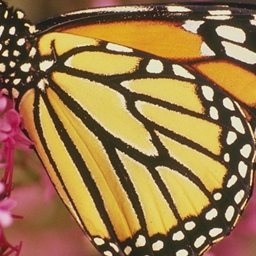

In [147]:
im

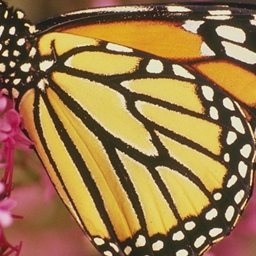

In [25]:
im = Image.open('D:\\datasets\\SRCNN-Tensorflow-master\\Test\\butterfly_GT.bmp')
im90 = im.rotate(90)
im

In [141]:
def jpeg_compress_no_save(img, level):
    out = BytesIO()
    im.save(out, format='jpeg', quality=level)
    out.seek(0)
    return out
c = Image.open(jpeg_compress_no_save(im, 40))

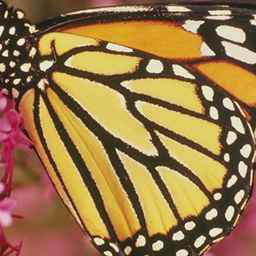

In [142]:
c

In [194]:
def create_noisified(img, level):
    img = np.array(img).astype(np.float32)
    img /= 255.
    img += level * np.random.normal(size=img.shape)
    img = np.clip(img, 0., 1.)
    return Image.fromarray(np.uint8(img * 255))

In [203]:
nc = create_noisified(c, .25)

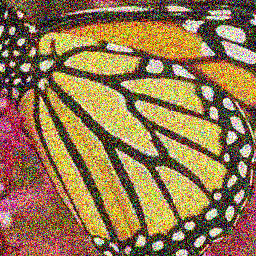

In [204]:
nc

In [170]:
print(np.array(c).shape)

(256, 256, 3)


In [211]:
def create_subimages(image_path, destination_dir, patch_width=160, patch_height=160):
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    img = Image.open(image_path)
    img_width, img_height = img.size
    img_height -= img_height % patch_height
    img_width -= img_width % patch_width
    k = 1
    for i in range(0, img_height, patch_height):
        for j in range(0, img_width, patch_width):
            box = (j, i, j + patch_width, i + patch_height)
            patch = Image.new('RGB', (patch_height, patch_width), 255)
            patch.paste(img.crop(box))
            patch.save(f'{destination_dir}{image_name}_{k}.jpg')
            k += 1

def copy_image(image_path, destination_dir):
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    img = Image.open(image_path)
    img.save(f'{destination_dir}{image_name}.jpg')

def create_compressed(img, destination_path, level, rotation):
    img = img.rotate(rotation)
    img.save(destination_path, format='jpeg', quality=level)

def create_noisified(img, destination_path, level, rotation):
    img = img.rotate(rotation)
    img = np.array(img).astype(np.float32)
    img /= 255.
    img += level * np.random.normal(size=img.shape)
    img = np.clip(img, 0., 1.)
    img = Image.fromarray(np.uint8(img * 255))
    img.save(destination_path)

def create_downscaled(img, destination_path, factor, rotation):
    img = img.rotate(rotation)
    img_width, img_height = img.size
    img = img.resize((int(img_width / factor), int(img_height / factor)), Image.BICUBIC)
    img = img.resize((img_width, img_height), Image.BICUBIC)
    img.save(destination_path)

def preprocess_bsds500():
    """
    Complete pre-process of the whole dataset and saving in a tar file.
    Not optimized for easier understanding (run only once anyway).
    """
    root_dir = 'D:\\datasets\\'
    dataset_dir = f'{root_dir}bsds500\\'
    temp_dir = f'{root_dir}temp\\'
    # Delete and create temp dir
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    # Write sub-images in temp/targets/train dir and copy others in corresponding temp/dirs
    for local_dir in ['train', 'test', 'val']:
        destination_dir = f'{temp_dir}targets\\{local_dir}\\'
        os.makedirs(destination_dir)
        igms_paths = glob.glob(f'{dataset_dir}{local_dir}\\*.jpg')
        for image_path in igms_paths:
            if local_dir == 'train':
                create_subimages(image_path, destination_dir)
            else:
                copy_image(image_path, destination_dir)
            break
    # Preprocess sub-images, create a downscaled, noisified and compressed version for each train and val image
    for local_dir in ['train', 'val']:
        destination_dir = f'{temp_dir}data\\{local_dir}\\'
        os.makedirs(destination_dir)
        igms_paths = glob.glob(f'{temp_dir}targets\\{local_dir}\\*.jpg')
        for image_path in igms_paths:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            img = Image.open(image_path)
            create_compressed(img, f'{destination_dir}{image_name}_c.jpg',
                              random.randint(1, 4) * 10, random.randint(0, 3) * 90 if local_dir == 'train' else 0)
            create_noisified(img, f'{destination_dir}{image_name}_n.jpg',
                              [.15, .25, .50][random.randint(0, 2)], random.randint(0, 3) * 90 if local_dir == 'train' else 0)
            create_downscaled(img, f'{destination_dir}{image_name}_d.jpg',
                              random.randint(2, 4), random.randint(0, 3) * 90 if local_dir == 'train' else 0)
    # Preprocess all test sets
    
    # Create tar file with temp dir
    
    # Delete temp dir
    #shutil.rmtree(temp_dir)

In [212]:
preprocess_bsds500()

In [85]:
os.path.splitext(os.path.basename('D:\\datasets\\bsds500\\train\\100075.jpg'))[0]

'100075'

In [116]:
os.makedirs(f'{root_dir}temp\\test\\')

In [126]:
test = glob.glob(f'{dataset_dir}val\\*.jpg')

In [127]:
test.append(glob.glob(f'{dataset_dir}test\\*.jpg'))

In [163]:
[15, 25, 50][random.randint(0, 2)]

25